**Requirements**:
- You need to have the `cognite-sdk` package installed
- The environment variable `COGNITE_API_KEY` should be set

In [1]:
%matplotlib inline
import pickle
import os

from sklearn.ensemble import RandomForestRegressor

from cognite.client.experimental import CogniteClient
from cognite.client.data_classes.time_series import TimeSeries
from cognite.model_hosting.data_fetcher import DataFetcher
from cognite.model_hosting.data_spec import *
from cognite.model_hosting.schedules import ScheduleOutput

client = CogniteClient()
mlh = client.model_hosting

# Introduction

In this tutorial we will train a simple model which will try to find the production rate of some imaginary equipment given the temperature, pressure and rotation speed.

Imagine that we are currently measuring the production rate of this equipment, but continously measuring the rate is costly.
We know that it should be possible infer the rate if we know the temperature, pressure and rotation speed.
So if we could make a model that infers the production rate based on other sensor readings we could cut costs.

Since this is an imaginary equipment, we will have to create some fake training and prediction data. We will post the training data backwards in time, and the data to predict on ahead in time. This will allow our prediction schedule to pick up "new" data, as it time progresses.

Run the script `generate_equipment_data.py` and paste the output into the following variable:

In [2]:
ts_ids = {
    'predicted_prod_rate': 6514100169226141,
    'pressure': 5337978820850062,
    'production_rate': 8031688873823130,
    'rpm': 6219610002944799,
    'temp': 1014968819786991
}

The first four time series are populated with sensor values, while the last one (predicted_production_rate) is a new time series we have created for the purpose of filling it with values from our model.

We'll use data from the last two days as training data.
Let's define a data spec for the training data and plot it:

In [3]:
training_data_spec = DataSpec(time_series={
    "temp": TimeSeriesSpec(
        id=ts_ids["temp"], 
        aggregate="average", 
        granularity="10s", 
        start="1d-ago", 
        end="now"
    ),
    "pressure": TimeSeriesSpec(
        id=ts_ids["pressure"], 
        aggregate="average", 
        granularity="10s", 
        start="1d-ago", 
        end="now"
    ),
    "rpm": TimeSeriesSpec(
        id=ts_ids["rpm"], 
        aggregate="average", 
        granularity="10s", 
        start="1d-ago", 
        end="now"
    ),
    "production_rate": TimeSeriesSpec(
        id=ts_ids["production_rate"], 
        aggregate="average", 
        granularity="10s", 
        start="1d-ago", 
        end="now"
    ),
})

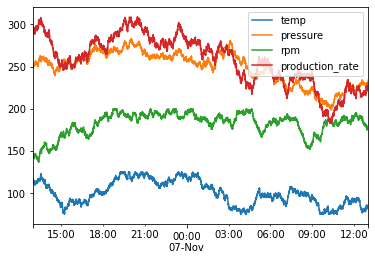

In [4]:
data_fetcher = DataFetcher(training_data_spec)
df = data_fetcher.time_series.fetch_dataframe(["temp", "pressure", "rpm", "production_rate"])
df.plot()

We are ready to start making our model!

# 1. Train a model artifact

In this tutorial, we will train a model locally using our newly created training data.

In [5]:
X = df[["temp", "pressure", "rpm"]].values
y = df["production_rate"].values

regressor = RandomForestRegressor(n_estimators=100)
regressor.fit(X, y)

# Persist our regressor model
if not os.path.isdir("artifacts"):
    os.mkdir("artifacts")
with open("artifacts/regressor.pickle", "wb") as f:
    pickle.dump(regressor, f)

# 1. Write the source package

The first thing we need to do is write the code for our model.
We do this by creating a Python package.
Our package is named `prod_rate` and can be found in a folder with the same name.
Please have a look!
It's just a regular Python package that is pip-installable.
In this tutorial we just load the trained model (which we will later upload to the hosting environment) and perform a prediction on it.

It's required that your model resides in a class named Model, and that this class is inside a module (i.e. file) named model (model.py). You can read more about this in the [docs](https://doc.cognitedata.com/concepts/model_hosting.html).
Notice that our requirements (packages that our model needs - in this case scikit-learn) are defined in `setup.py`.

# 2. Create a source package

Before we use our code in Model Hosting we have to upload it.

In [6]:
source_package_id = mlh.source_packages.build_and_upload_source_package(
    name="prod-rate-v01",
    runtime_version="0.1",
    description="Some description", # Optional
    metadata={"interesting-metadata": "anything"}, # Optional
    package_directory="prod_rate"
).id

# 3. Create a model

A model in Model Hosting is an abstract resource that can consist of any number of model versions.
So before we create and train a specific model version, we need to have a model that will act as a parent container. You can read more about this in the docs.

In [7]:
model_name = "tutorial-model"
mlh.models.create_model(
    name=model_name,
    input_fields=[
        {"name": "temp", "type": "TIME_SERIES"},
        {"name": "pressure", "type": "TIME_SERIES"}, 
        {"name": "rpm", "type": "TIME_SERIES"}
    ],
    output_fields=[{"name": "production_rate", "type": "TIME_SERIES"}],
    description="Some description", # Optional
    metadata={"interesting-metadata": "anything"}, # Optional
)

Notice that we define the names of the input and output of our model.
This is necessary if want to use the model for scheduled prediction.
Our model is going to predict `production_rate` given the inputs `temp`, `pressure` and `rpm`.

# 4. Create and deploy a model version

A model version is a specific instance that can do a prediction.
It uses a source package like the one you created earlier and resides under a model like the one you just created.

When we specify the parameter `artifacts_directory`, we will upload all files located in that directory to the environment where your hosted model can access them. In our case, this will be the random forest regressor we just trained.

In [9]:
version_name = "tutorial-model-version"
mlh.versions.deploy_model_version(
    model_name=model_name,
    version_name=version_name,
    source_package_id=source_package_id,
    description="Some description", # Optional
    metadata={"interesting-metadata": "anything"}, # Optional
    artifacts_directory="artifacts"
)

Now we just have to wait for our model to be trained and deployed.
We can check the status until its 'READY'. This will take approximately 1-2 minutes as machines for serving your model are being allocated.

<font color='red'>The rest of the notebook will not work if you don't wait until the model version is ready!</font>

In [13]:
mlh.versions.get_model_version(model_name, version_name).status

'READY'

# 5. (Optional) Test predict manually

Now that our model version is ready we can use it to predict.
Let's try to give it a data spec.
We'll try using temperature, pressure and rotation speed from the last five minutes.

In [14]:
predict_response = mlh.models.online_predict(
    model_name=model_name,
    version_name=version_name,
    instances=[
        DataSpec(
            time_series={
                "temp": TimeSeriesSpec(
                    id=ts_ids["temp"], 
                    aggregate="average", 
                    granularity="10s", 
                    start="10m-ago", 
                    end="now"
                ),
                "pressure": TimeSeriesSpec(
                    id=ts_ids["pressure"], 
                    aggregate="average", 
                    granularity="10s", 
                    start="10m-ago", 
                    end="now"
                ),
                "rpm": TimeSeriesSpec(
                    id=ts_ids["rpm"], 
                    aggregate="average", 
                    granularity="10s", 
                    start="10m-ago", 
                    end="now"
                )
    })]
)

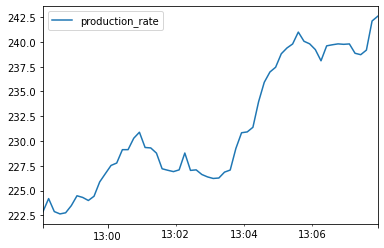

In [15]:
df = ScheduleOutput(predict_response[0]).get_dataframe("production_rate")
df.plot()

Now you could evaluate your model or do some other checks, but we will assume that everything looks fine.
We'll go ahead and create a schedule.

# 6. Create schedule

Schedules regularly run `predict` on some specified inputs using some specified model and writes to specified output.
It's important to note that schedules use models (not model versions directly) to perform predictions.
So you can actually change the implementation of the model by creating a new model version and then setting this as the model's active version.
When you change the active version of a model, it will take immediate effect on all schedules using that model.

Creating a schedule is simply a matter of specifying the model, the input data and the output data.
Specifying the input data is done by using a special data spec that uses `windowSize` and `stride` instead of `start` and `end`.
`windowSize` is the timespan of datapoints that each individual prediction will receive,
while `stride` is how often to do prediction.
Note that if `stride < windowSize` you will receive the same datapoints multiple times because windows overlap.
This can be useful if your model needs some look-back for each prediction. With the (optional) `slack` argument you can specify that you want Model Hosting to redo predictions for late/changing input data for a while.

We'll set up our schedule to read from `temp`, `pressure`, `rpm` and write predictions to `predicted_production_rate`.

In [16]:
schedule_data_spec = ScheduleDataSpec(
    input = ScheduleInputSpec(
        time_series={
            "temp": ScheduleInputTimeSeriesSpec(
                id=ts_ids["temp"], 
                aggregate="average", 
                granularity="10s"
            ),
            "rpm": ScheduleInputTimeSeriesSpec(
                id=ts_ids["pressure"], 
                aggregate="average", 
                granularity="10s"
            ),
            "pressure": ScheduleInputTimeSeriesSpec(
                id=ts_ids["rpm"], 
                aggregate="average", 
                granularity="10s"
            )
        }
    ),
    output = ScheduleOutputSpec(
        time_series={
            "production_rate": ScheduleOutputTimeSeriesSpec(id=ts_ids["predicted_prod_rate"])
        }
    ),
    stride="1m",
    window_size="1m",
    slack="5m",
)

In [17]:
schedule_name = "tutorial-schedule"
mlh.schedules.create_schedule(
    model_name=model_name,
    schedule_name=schedule_name,
    schedule_data_spec=schedule_data_spec,
    args={}, # Optional - Will be passed to all predictions
    description="Some description", # Optional
    metadata={"interesting-metadata": "anything"}, # Optional
)

Now we just have to wait.
We will get the first datapoints in approximately one minute.

# 7. Check the output

When we have waited a while we can take a look at the output.
Let's compare the measured and the predicted production rate the last 5 minutes:

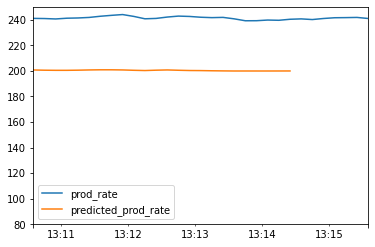

In [20]:
start="5m-ago"
data_spec = DataSpec(
    time_series={
        "predicted_prod_rate": TimeSeriesSpec(
            id=ts_ids["predicted_prod_rate"], 
            start=start, 
            end="now", 
            aggregate="average", 
            granularity="10s"
        ),
        "prod_rate": TimeSeriesSpec(
            id=ts_ids["production_rate"], 
            start=start, 
            end="now", 
            aggregate="average", 
            granularity="10s"
        )
})
data_fetcher = DataFetcher(data_spec)
df = data_fetcher.time_series.fetch_dataframe(["prod_rate", "predicted_prod_rate"])
df.plot(ylim=(80, 250))

Not perfect - it can probably be better.
You can try to improve it, upload the new source package, train a new model version and then change the active version of this model.

# 8. Clean up

Delete the model after finishing the tutorial. This will remove all versions under this model, 
so they no longer consume resources.

In [21]:
mlh.models.delete_model(model_name)
mlh.source_packages.delete_source_package(source_package_id)